## Data Loading and cleaning 


In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from PIL import Image
import os
import joblib


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

Test the access to the data


In [55]:
image_path = "data/SIH_NN/Plains/meadow_123.jpg"
image = Image.open(image_path)

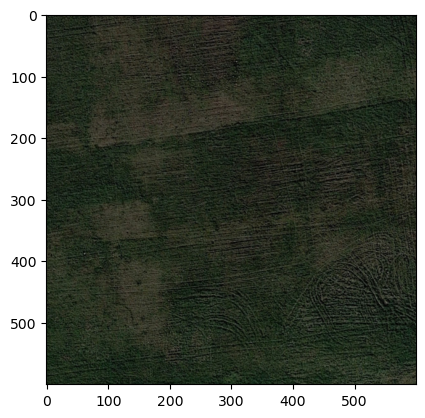

In [56]:
plt.imshow(image)
plt.show()

In [57]:
#path to the main folder: 
main = "data/SIH_NN"


image_paths = []
labels = []

for label in os.listdir(main):
    folder_path = os.path.join(main, label)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if file_name.endswith(".jpg"):
                image_paths.append(os.path.join(folder_path, file_name))
                labels.append(label)


In [58]:
# scale the pictures to a 256 by 256 size
img_size = (256, 256)

# seperate pixel data and label as X and y 
X = []
y = []

# load pic
for img_path, label in zip(image_paths, labels):
    image = Image.open(img_path)
    image = image.resize(img_size)  # scale pic
    image_array = np.array(image)  # picture to numpy array
    X.append(image_array)
    y.append(label)

# convert lists in np.arrays
X = np.array(X)
y = np.array(y)


In [51]:
label_dict= {
    "Desert": 0,
    "Forest":1,
    "Mountain":2,
    "Plains":3
}
num_y = []

for label in y:
    num_y.append(label_dict[label])


y = np.array(num_y)

In [59]:
#normalization 
X = X/X.max()

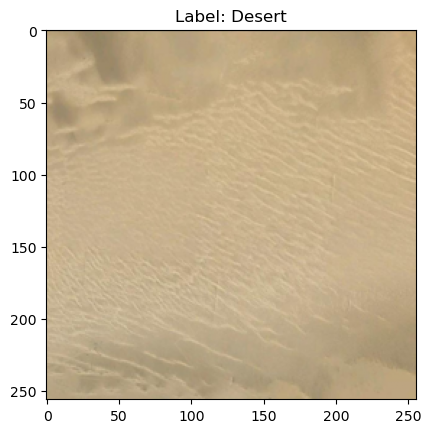

In [72]:
# Example
for i in [132]:
    plt.imshow(X[i])
    plt.title(f"Label: {y[i]}")
    plt.show()


In [70]:
print(f"X shape:{X.shape}")
print(f"y shape:{y.shape}")

X shape:(3196, 256, 256, 3)
y shape:(3196,)


In [74]:
joblib.dump(X, '../data/X.pkl')
joblib.dump(y,'../data/y.pkl')

['../data/y.pkl']

Next steps: 

Next, the individual images are processed in a CNN algorithm to build a simple identification. 